In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('cleaned_data.csv')
rfm_df = pd.read_csv('RFM_features.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397885 entries, 0 to 397884
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Invoice         397885 non-null  int64  
 1   StockCode       397885 non-null  object 
 2   Description     397885 non-null  object 
 3   Quantity        397885 non-null  int64  
 4   InvoiceDate     397885 non-null  object 
 5   Price           397885 non-null  float64
 6   Customer ID     397885 non-null  float64
 7   Country         397885 non-null  object 
 8   SalesLineTotal  397885 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 27.3+ MB


In [4]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer ID      3911 non-null   float64
 1   MonetaryValue    3911 non-null   float64
 2   Frequency        3911 non-null   int64  
 3   LastInvoiceDate  3911 non-null   object 
 4   Recency          3911 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 152.9+ KB


In [14]:
rfm_df = rfm_df.drop(['LastInvoiceDate'], axis=1)

In [16]:
# Scale the data

ss = StandardScaler()
ss.fit(rfm_df.drop('Customer ID', axis=1))
X = ss.transform(rfm_df.drop('Customer ID', axis=1))
X

array([[ 1.0991622 ,  0.42564962, -0.24501321],
       [ 1.0512524 , -0.7455856 , -0.79636343],
       [-0.66663203, -0.7455856 ,  2.06868859],
       ...,
       [-0.85536213, -0.35517386, -0.90466436],
       [ 1.45844346,  5.11059051, -0.94404652],
       [ 1.14749449,  0.03523788, -0.56007048]])

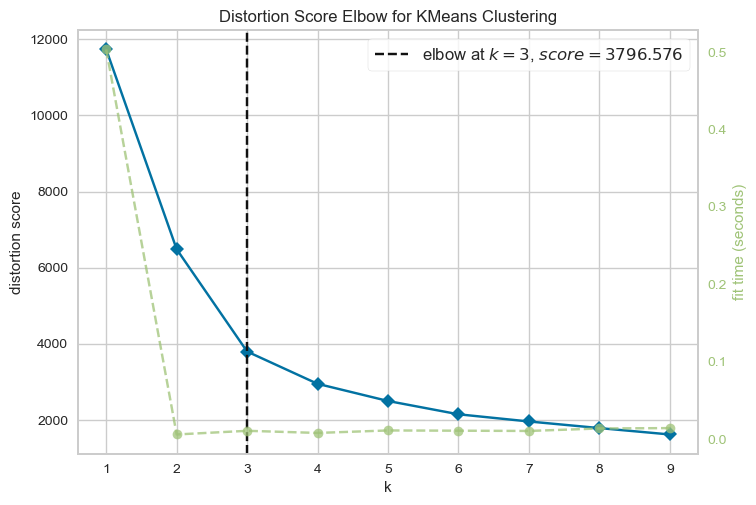

In [8]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init='auto')
visualizer = KElbowVisualizer(model, k=(1,10), locate_elbow=True)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.poof()        # Draw/show/poof the data
plt.show()

----------------------------------------------------------------------
For n_clusters = 2 The average silhouette_score is : 0.4614918663974883


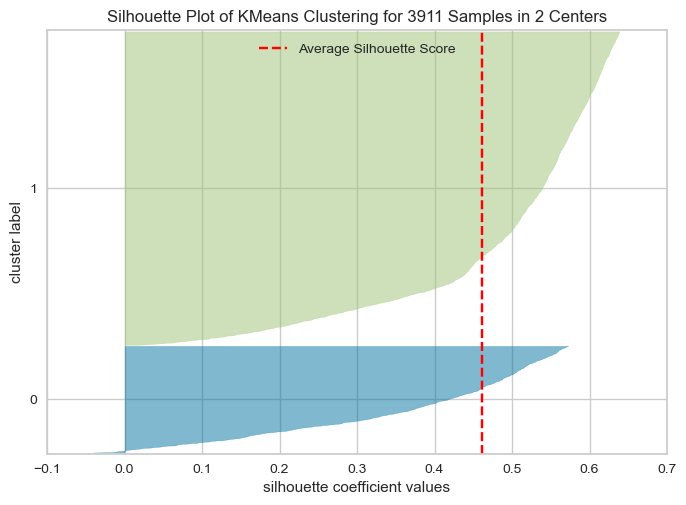

----------------------------------------------------------------------
For n_clusters = 3 The average silhouette_score is : 0.4679272710486727


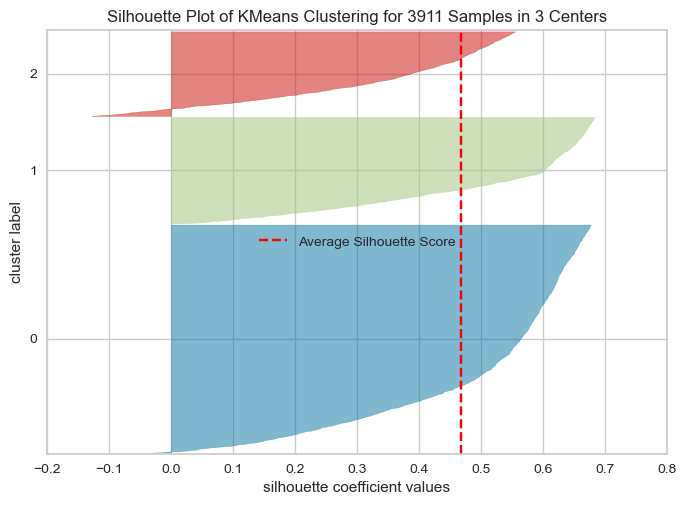

----------------------------------------------------------------------
For n_clusters = 4 The average silhouette_score is : 0.4312186763011235


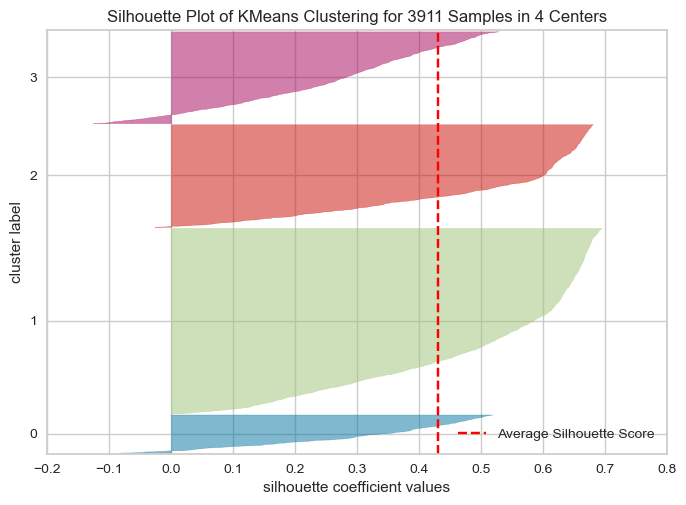

----------------------------------------------------------------------
For n_clusters = 5 The average silhouette_score is : 0.40656721122080514


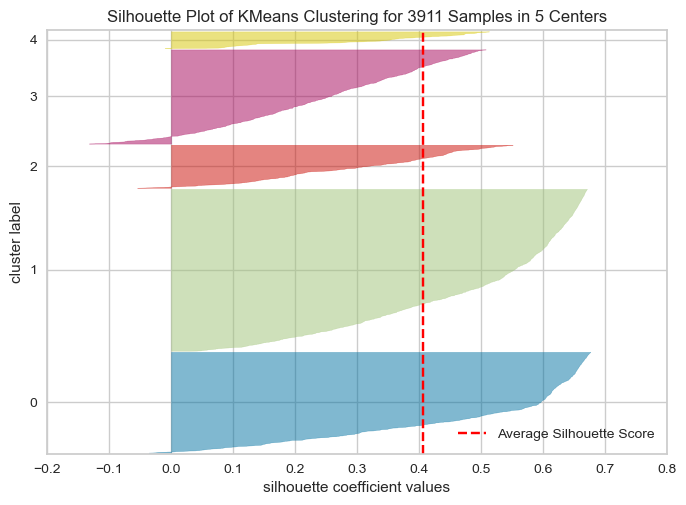

In [10]:
# Silhouette Visualizer

search_name = 'kmeans'

n_clusters = np.arange(2,6,1).tolist()

for n_clusters in n_clusters:

    print('-'*70)

    model = KMeans()

    param_dict = {'n_clusters': n_clusters,
                  'n_init': 10,
                  'random_state':42,
                 # 'algorithm':'auto' #'lloyd' or 'elkan'
                 }

    model.set_params(**param_dict)
    labels = model.fit_predict(X)

    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.poof()

### From the above elbow method and silhouette score , we can see that the optimal number of clusters is 4. So 4 clusters in our KMeans model

In [17]:
# Based on the above analysis we can go with 4 clusters 

optimal_k = 4  # from the elbow method and silhouette score

kmeans = KMeans(n_clusters=optimal_k, random_state=42)

rfm_df["Cluster"] = kmeans.fit_predict(rfm_df.drop(columns=['Customer ID'], axis=1))


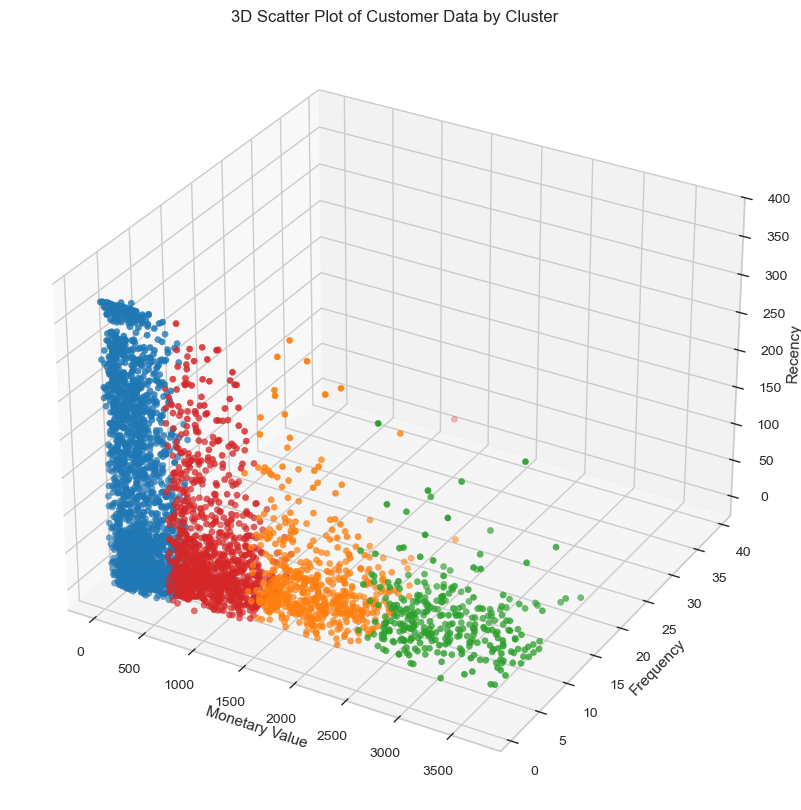

In [18]:
# plot the clusters in 3D

cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                  3: '#d62728'}  # Red

colors = rfm_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(rfm_df['MonetaryValue'], 
                     rfm_df['Frequency'], 
                     rfm_df['Recency'], 
                     c=colors,  # Use mapped solid colors
                     marker='o')

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

In [19]:
rfm_df.head()

,Customer ID,MonetaryValue,Frequency,Recency,Cluster
0,12348.0,1797.24,4,74,1
1,12349.0,1757.55,1,18,1
2,12350.0,334.40,1,309,0
3,12352.0,2506.04,8,35,2
4,12353.0,89.00,1,203,0


In [ ]:
rfm_df.groupby('Cluster').mean()

,Customer ID,MonetaryValue,Frequency,Recency
Cluster,,,,
0,15451.750626,294.697983,1.494742,137.301953
1,15300.096948,1798.303806,5.172352,50.285458
2,15102.594937,2942.492218,7.148734,36.433544
3,15209.959654,910.402748,3.126801,70.151777


### From the above mean values we can see 4 different type of customers and named them as:

- Cluster 0 "Inactive" -> Low spenders, infrequent purchases, need reactivation.	
- Cluster 1 "Churn Risk" -> Customers at risk of leaving, need marketing intervention.	
- Cluster 2 "Loyal" -> High spenders, frequent buyers, best customers.	
- Cluster 3"Growing" ->	Customers increasing engagement, need further nurturing.

In [23]:
label_dict = {0: 'Inactive',
              1: 'Churn Risk',
              2: 'Loyal',
              3: 'Growing'} 

rfm_df['labels'] = rfm_df['Cluster'].map(label_dict)

In [24]:
rfm_df.head()

,Customer ID,MonetaryValue,Frequency,Recency,Cluster,labels
0,12348.0,1797.24,4,74,1,Churn Risk
1,12349.0,1757.55,1,18,1,Churn Risk
2,12350.0,334.40,1,309,0,Inactive
3,12352.0,2506.04,8,35,2,Loyal
4,12353.0,89.00,1,203,0,Inactive


In [29]:
df_with_labels = df.merge(
    rfm_df[['Customer ID','Cluster', 'labels', 'Recency', 'Frequency', 'MonetaryValue']], 
    on='Customer ID', 
    how='inner'
)

In [30]:
df_with_labels.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,SalesLineTotal,Cluster,labels,Recency,Frequency,MonetaryValue
0,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom,25.50,2,Loyal,31,10,3237.54
1,536368,22913,RED COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85,2,Loyal,31,10,3237.54
2,536368,22912,YELLOW COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85,2,Loyal,31,10,3237.54
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,2010-12-01 08:34:00,4.95,13047.0,United Kingdom,14.85,2,Loyal,31,10,3237.54
4,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08,2,Loyal,31,10,3237.54


In [31]:
df_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240594 entries, 0 to 240593
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Invoice         240594 non-null  int64  
 1   StockCode       240594 non-null  object 
 2   Description     240594 non-null  object 
 3   Quantity        240594 non-null  int64  
 4   InvoiceDate     240594 non-null  object 
 5   Price           240594 non-null  float64
 6   Customer ID     240594 non-null  float64
 7   Country         240594 non-null  object 
 8   SalesLineTotal  240594 non-null  float64
 9   Cluster         240594 non-null  int32  
 10  labels          240594 non-null  object 
 11  Recency         240594 non-null  int64  
 12  Frequency       240594 non-null  int64  
 13  MonetaryValue   240594 non-null  float64
dtypes: float64(4), int32(1), int64(4), object(5)
memory usage: 24.8+ MB


In [32]:
df_with_labels.to_csv('clustered_data.csv')